# Goal:
Predict the apple stock price in next day by using linear regression

Given prices for the last N days, we train a model, and predict for day N+1



In [317]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline


In [275]:

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
apple_data = pd.read_csv('../ML-Project/apple.csv')

#print the head
apple_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Quarter
0,0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,2017,1
1,1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,2017,1
2,2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,2017,1
3,3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,2017,1
4,4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,2017,1


In [280]:
#apple_data.drop('Year', 'Quarter', inplace=True)
apple = apple_data.drop(columns=['Unnamed: 0', 'Year', 'Quarter'])
apple.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900


In [282]:
apple['Date'] = pd.to_datetime(apple.Date,format='%Y-%m-%d')


In [286]:

apple['Month'] = apple['Date'].dt.month
apple.head()


,Date,Open,High,Low,Close,Adj_Close,Volume,Month
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,1
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,1
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,1
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,1
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,1


There are multiple variables in the dataset – date, open, high, low, close, & volume.

The columns open and close represent the starting and final price at which the stock is traded on a particular day. High and low represent the maximum, minimum, and last price of the share for the day. Volume is the number of shares bought or sold in the day.

Another important thing to note is that the market is closed on weekends and public holidays. Thats's why in the table some date values are missing.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

Text(0, 0.5, 'Price USD')

<Figure size 864x576 with 0 Axes>

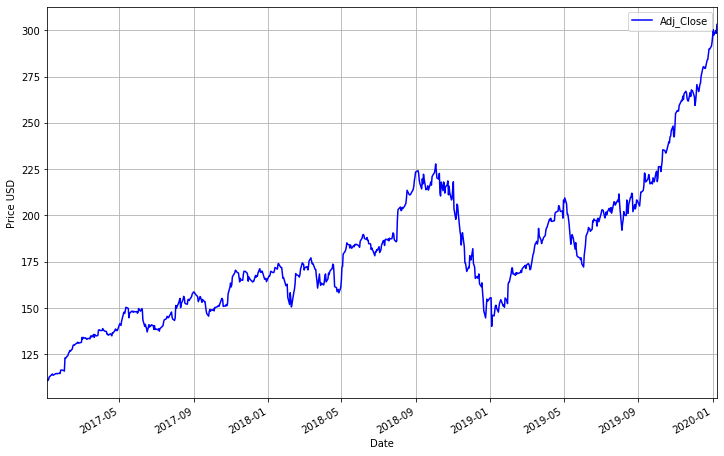

In [287]:

#plot
plt.figure(figsize=(12,8))

ax = apple.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")



Linear Regression
Introduction

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

The equation for linear regression can be written as:

Here, x1, x2,….xn represent the independent variables while the coefficients θ1, θ2, …. θn represent the weights. You can refer to the following article to study linear regression in more detail:

we do not have a set of independent variables. We have only the dates instead. Let us use the date column to extract features like – day, month, year, mon/fri etc. and then fit a linear regression model.

Implementation

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [288]:
# Input paramaters
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [289]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(apple))
num_test = int(test_size*len(apple))
num_train = len(apple) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 457
num_cv = 151
num_test = 151


In [290]:
# Split into train, cv, and test
train = apple[:num_train].copy()
cv = apple[num_train:num_train+num_cv].copy()
train_cv = apple[:num_train+num_cv].copy()
test = apple[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (457, 8)
cv.shape = (151, 8)
train_cv.shape = (608, 8)
test.shape = (151, 8)


Text(0, 0.5, 'Price USD')

<Figure size 864x576 with 0 Axes>

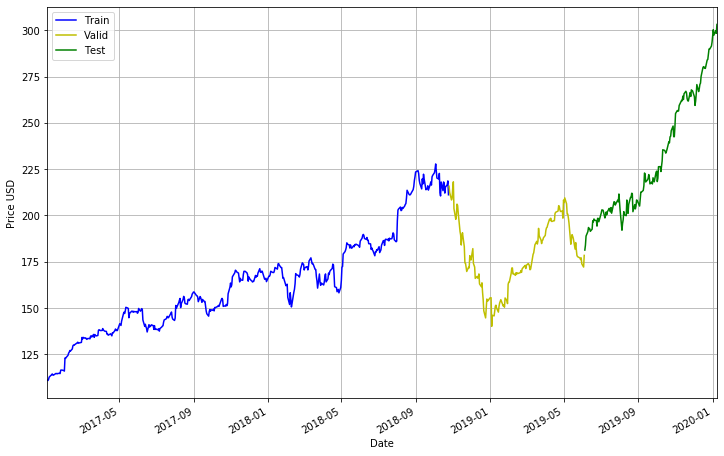

In [291]:
#plot
plt.figure(figsize=(12,8))
ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Valid', 'Test'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")

# Prediction by Linear Regression

In [292]:
def get_preds_lin_reg(apple, target_col, N, pred_min, offset):
    
    #get prediction at timestep t using values from t-1, t-2, ..., t-N.
      # target_col : name of the column you want to predict e.g. 'adj_close'
       # N: get prediction at timestep t using values from t-1, t-2, ..., t-N
        #pred_min : all predictions should be >= pred_min
       # offset: it can be size of training set
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(apple['Adj_Close'])):
        X_train = np.array(range(len(apple['Adj_Close'][i-N:i])))
        y_train = np.array(apple['Adj_Close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
        y_train = y_train.reshape(-1, 1)
    # Train the model
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [293]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'Adj_Close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['Adj_Close'])))
    R2.append(r2_score(cv['Adj_Close'], est_list))
    mape.append(get_mape(cv['Adj_Close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()   

RMSE = [3.905844315921211, 5.596721327964514, 5.019769206295928, 4.978407638862982, 4.975430954803471, 4.927458913058318, 4.885796112664123, 4.774656725135466, 4.720793969367129, 4.726949101484141, 4.800000942074946, 4.85372303056591, 4.855911214335038, 4.867761241314721, 4.905053135567641, 5.017137184788405, 5.17168529324248, 5.296857848490742, 5.404598900164277, 5.50377288938014, 5.614150084488982, 5.724206007828147, 5.839341458931085, 5.950108670658729, 6.090340242855644, 6.248246388453958, 6.402119491635694, 6.5721530415423555, 6.7210360381116745, 6.869625398367043]
R2 = [0.9546597568674318, 0.9069060723883529, 0.9251104040398958, 0.9263394603756515, 0.9264275201003361, 0.9278394207547033, 0.9290545305749923, 0.932245476695471, 0.9337655276266658, 0.933592697502918, 0.9315242760281854, 0.9299829243052571, 0.9299197790605873, 0.9295773239532514, 0.9284941752568734, 0.9251889173513368, 0.9205089623540113, 0.9166144834786821, 0.9131877675891694, 0.9099725401333904, 0.906325361777494, 

,Date,Open,High,Low,Close,Adj_Close,Volume,Month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
457,2018-10-25,217.710007,221.380005,216.750000,219.800003,215.793457,29855800,10,211.169296,203.668563,...,213.231951,213.712723,214.248801,214.962671,215.374323,215.851262,216.264190,216.639170,216.553083,216.317439
458,2018-10-26,215.899994,220.190002,212.669998,216.300003,212.357239,47258400,10,215.793457,220.417618,...,212.537606,213.234206,213.673825,214.172489,214.847507,215.238214,215.695100,216.093587,216.457955,216.378626
459,2018-10-29,219.190002,219.690002,206.089996,212.240005,208.371262,45935500,10,212.357239,208.921021,...,211.684539,211.980851,212.648590,213.076247,213.563741,214.223968,214.614393,215.070206,215.471394,215.840795
460,2018-10-30,211.149994,215.179993,209.270004,213.300003,209.411926,36660000,10,208.371262,204.385285,...,210.278503,210.517376,210.826997,211.493070,211.932136,212.429835,213.095195,213.502643,213.973492,214.392107
461,2018-10-31,216.880005,220.449997,216.619995,218.860001,214.870590,38358900,10,209.411926,210.452590,...,209.423472,209.485749,209.721087,210.025818,210.674681,211.109667,211.603293,212.260858,212.672401,213.146363


(2, 30)

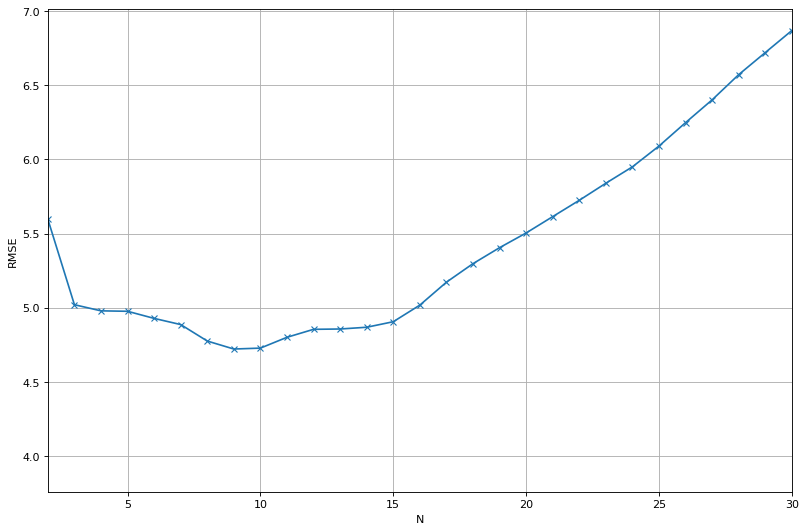

In [294]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Text(0, 0.5, 'R2')

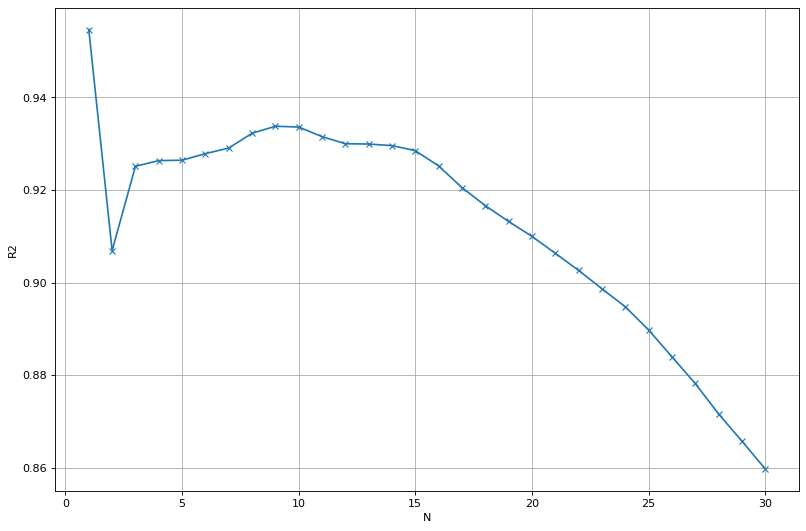

In [295]:
# Plot R2 versus N (R2 larger better)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, '-x')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

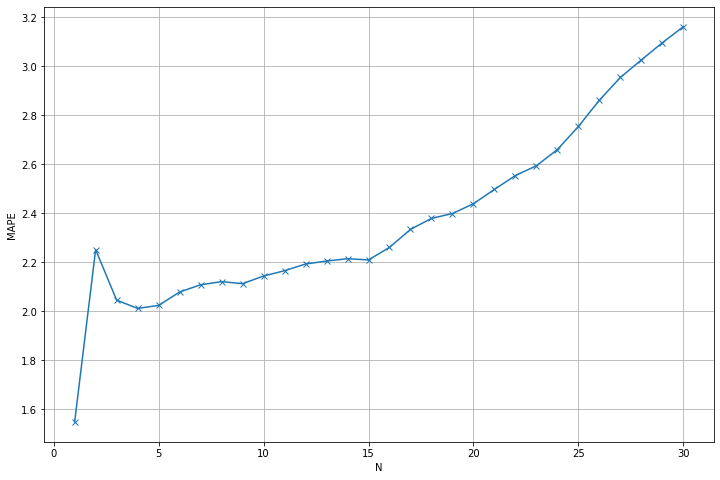

In [296]:
# Plot MAPE versus N. (MAPE smaller better) 
plt.figure(figsize=(12, 8))
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

# Predictions for a specific day by plot

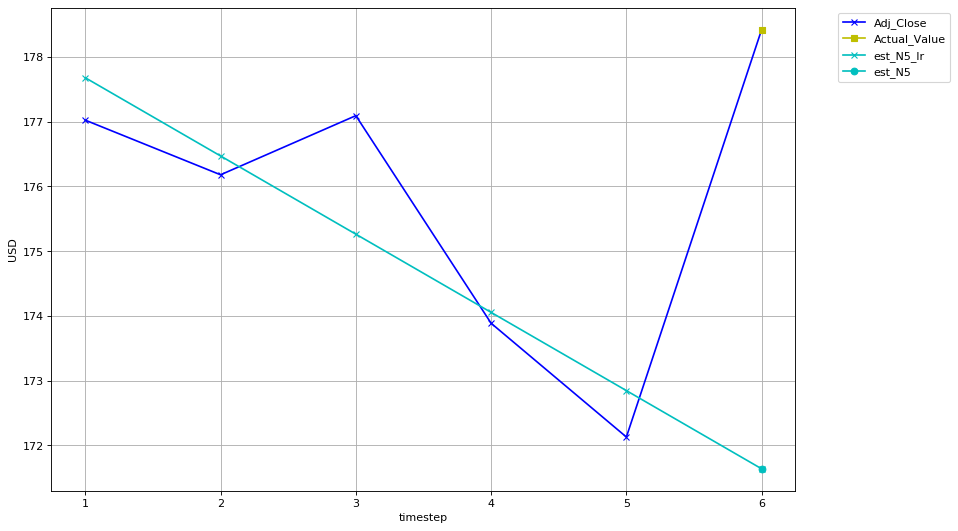

In [321]:
# Specify the day you are interested in
day = pd.Timestamp(date(2019, 10, 31))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['Date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['Adj_Close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['Adj_Close'], 'ys-')
legend_list = ['Adj_Close', 'Actual_Value']
# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['Adj_Close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['Adj_Close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})


# Plot predictions on dev set

Text(0, 0.5, 'USD')

<Figure size 864x576 with 0 Axes>

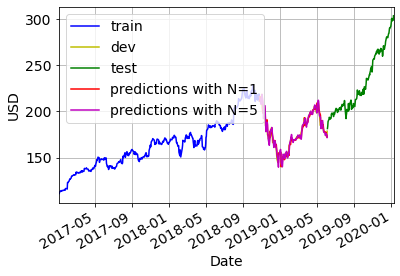

In [325]:
# Plot adjusted close over time
plt.figure(figsize=(12, 8))

ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")

<Figure size 864x576 with 0 Axes>

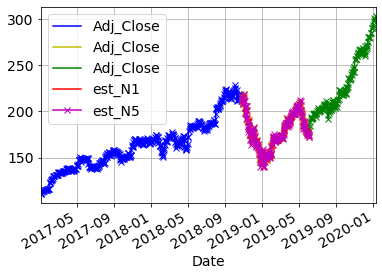

In [327]:
# Plot adjusted close over time
plt.figure(figsize=(12, 8))
ax = train.plot(x='Date', y='Adj_Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([Date(2019, 11, 1), Date(2019, 12, 30)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

